In [ ]:
# %matplotlib inline
import torch
from torch import nn
import matplotlib.pyplot as plt

T = 1000
time_step = torch.arange(1, T + 1, dtype=torch.float32)
# torch.normal(mean, std, size)，结果张量的形状是一维、长度为 T 的向量
x = torch.sin(0.01 * time_step) + torch.normal(0, 0.2, (T,))

plt.figure(figsize=(6, 3))
plt.plot(time_step.numpy(), x.numpy())
plt.xlabel('time_step')
plt.ylabel('x')
plt.xlim(1, 1000)
plt.grid(True)
plt.show()


将数据映射为数据对 $y_t = x_t$ 和 $\mathbf{x}_t = [x_{t - \tau}, \dots, x_{t - 1}]$

In [ ]:
from ml_utils import *
tau = 4
# T - tau是样本数，tau是特征数
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i: T - tau + i]

labels = x[tau:].reshape((-1, 1))

batch_size, n_train = 16, 600
train_iter = load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)

In [26]:
import torch
from torch import nn

# 自定义权重初始化函数
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

# 定义网络结构
def get_net():
    net = nn.Sequential(
        nn.Linear(4, 10),   # 输入维度为 4，隐藏层神经元 10 个
        nn.ReLU(),
        nn.Linear(10, 1)    # 输出为 1（回归任务）
    )
    net.apply(init_weights)  # 应用权重初始化
    return net

# 损失函数：均方误差
loss = nn.MSELoss()

In [27]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
              f'loss: {evaluate_loss(net, train_iter, loss):.6f}')

# 初始化网络并开始训练
net = get_net()
train(net, train_iter, loss, 5, 0.01)


epoch 1, loss: 0.064972
epoch 2, loss: 0.057170
epoch 3, loss: 0.052719
epoch 4, loss: 0.052234
epoch 5, loss: 0.052783


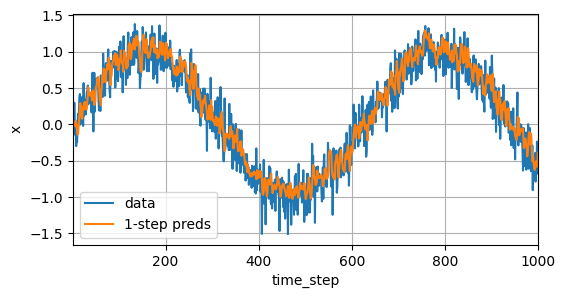

In [28]:
onestep_preds = net(features)


plt.figure(figsize=(6, 3))
plt.plot(time_step.numpy(), x.detach().numpy(), label='data')
plt.plot(time_step[tau:].numpy(), onestep_preds.detach().numpy(), label='1-step preds')
plt.xlabel('time_step')
plt.ylabel('x')
plt.xlim(1, 1000)
plt.legend()
plt.grid(True)
plt.show()

In [29]:
import collections
import re

import requests

with open(r"F:\000-CS\LIMU_BILIBILI\timemachine.txt", 'r') as f:
    lines = f.readlines()

print(lines[0])
print(lines[10])

The Time Machine, by H. G. Wells [1898]

twinkled, and his usually pale face was flushed and animated. The



In [1]:
import re
import requests

# 如果本地没有文件就下载
import os

# 加载并清洗文本
def read_time_machine():
    """Load the time machine dataset into a list of cleaned text lines."""
    with open(r"F:\000-CS\LIMU_BILIBILI\timemachine.txt", 'r', encoding='utf-8') as f:
        lines = f.readlines()
    # 把不是大小写字母的东西全部变成空格
    # re.sub(pattern, replacement, string)：表示用 replacement 替换 string 中所有匹配 pattern 的部分。
    # .strip()去除处理后字符串的首尾空格。
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]

# 读取数据
lines = read_time_machine()

# 打印前几行
print(lines[0])
print(lines[10])


the time machine by h g wells
twinkled and his usually pale face was flushed and animated the


In [31]:
def tokenize(lines, token='word'):
    """将文本行拆分为单词或字符标记。"""
    if token == 'word':
        return [line.split() for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('错误：未知令牌类型：' + token)

tokens = tokenize(lines)
for i in range(11):
    print(tokens[i])


['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
[]
[]
[]
[]
['i']
[]
[]
['the', 'time', 'traveller', 'for', 'so', 'it', 'will', 'be', 'convenient', 'to', 'speak', 'of', 'him']
['was', 'expounding', 'a', 'recondite', 'matter', 'to', 'us', 'his', 'grey', 'eyes', 'shone', 'and']
['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']


构建一个字典，通常也叫做词汇表（vocabulary），用于将字符串类型的标记映射到从 0 开始的数字索引中

In [32]:

import collections

def count_corpus(tokens):
    """统计标记的频率"""
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # 将二维嵌套列表展平
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

class Vocab:
    """文本词汇表"""
    # min_freq表示一个阈值，如果出现的次数少于它的话就统一归类成"unknown"
    # reserved_tokens: 保留符号，如 <pad>、<bos>、<eos> 等特殊token。
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []

        counter = count_corpus(tokens)
        # 所以这个 lambda 函数表示：按照每个元素的第 2 项（即词频）排序;reverse=True表示降序排列（从大到小），默认是升序。
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1], reverse=True)

        # unk表示unknown;
        #     <unk>	处理低频或未知词汇
        #     <pad>	填充序列对齐长度
        #     <bos>	序列起始（begin of sentence）
        #     <eos>	序列结束（end of sentence）
        self.unk, uniq_tokens = 0, ['<unk>'] + reserved_tokens
        uniq_tokens += [
            token for token, freq in self.token_freqs
            if freq >= min_freq and token not in uniq_tokens
        ]

        self.idx_to_token, self.token_to_idx = [], {}
        for token in uniq_tokens:
            self.idx_to_token.append(token)
            self.token_to_idx[token] = len(self.idx_to_token) - 1


    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]


In [33]:
# 创建词汇表
vocab = Vocab(tokens)
# 打印词到索引映射的前 10 项
print(list(vocab.token_to_idx.items())[:10])

[('<unk>', 0), ('the', 1), ('i', 2), ('and', 3), ('of', 4), ('a', 5), ('to', 6), ('was', 7), ('in', 8), ('that', 9)]


In [34]:
for i in [0,10]:
    print("words", tokens[i])
    print("indices", vocab[tokens[i]])

words ['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
indices [1, 19, 50, 40, 2183, 2184, 400]
words ['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']
indices [2186, 3, 25, 1044, 362, 113, 7, 1421, 3, 1045, 1]


In [35]:
# 主函数：加载语料和词汇表
def load_corpus_time_machine(max_tokens=-1):
    """返回时光机器数据集的标记索引列表和词汇表。"""
    lines = read_time_machine()
    tokens = tokenize(lines, 'char')
    # tokens = tokenize(lines, 'word')
    vocab = Vocab(tokens)
    corpus = [vocab[token] for line in tokens for token in line]  # 展平为 index 序列
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab

# -------------------------------
# 示例调用
# corpus表示每个token对应的index，是一个时序的序列
corpus, vocab = load_corpus_time_machine()
print("corpus:", corpus[:10])
for token_idx in corpus[:10]:
    print(vocab.idx_to_token[token_idx])
print("词元数量：", len(corpus))
print("词汇表大小：", len(vocab))

corpus: [3, 9, 2, 1, 3, 5, 13, 2, 1, 13]
t
h
e
 
t
i
m
e
 
m
词元数量： 170580
词汇表大小： 28


In [36]:
for idx, token in enumerate(vocab.idx_to_token):
    print(f'{idx}: {token}')

0: <unk>
1:  
2: e
3: t
4: a
5: i
6: n
7: o
8: s
9: h
10: r
11: d
12: l
13: m
14: u
15: c
16: f
17: w
18: g
19: y
20: p
21: b
22: v
23: k
24: x
25: z
26: j
27: q


# 语言模型（Language Model）

给定文本序列 $( x_1, \ldots, x_T )$，语言模型的目标是估计联合概率：

$$
p(x_1, x_2, \ldots, x_T)
$$

---

## 它的应用包括：

- **做预训练模型**（例如 BERT，GPT-3）
- **生成文本**：给定前面几个词，不断地使用
  $$
  x_t \sim p(x_t \mid x_1, \ldots, x_{t-1})
  $$
  来生成后续文本
- **判断多个序列中哪个更常见**，例如：
  - "to recognize speech"
  - vs
  - "to wreck a nice beach"

---

> 语言模型的核心是建模自然语言的概率分布，可用于预测、生成和评估句子的自然性。


# 📘 语言模型：马尔可夫模型、n 元语法与拉普拉斯平滑笔记

## 一、马尔可夫模型（Markov Model）

马尔可夫假设是语言建模中常用的一种简化假设，假设当前时刻的状态仅依赖于有限的前几个状态。

若有：

$$
P(x_{t+1} \mid x_t, x_{t-1}, \dots, x_1) = P(x_{t+1} \mid x_t)
$$

则称该序列满足一阶马尔可夫性质。

随着所依赖的历史长度增加，马尔可夫模型就拓展为高阶马尔可夫模型。

---

## 二、n 元语法模型（n-gram Language Model）

n-gram 模型是基于马尔可夫假设的语言建模方法，用于估计一个词序列出现的概率。

### 1. 联合概率展开

以 4 元语法为例：

- 无条件独立（Unigram）模型：

$$
P(x_1, x_2, x_3, x_4) = P(x_1)P(x_2)P(x_3)P(x_4)
$$

- 一阶马尔可夫（二元语法，Bigram）模型：

$$
P(x_1, x_2, x_3, x_4) = P(x_1)P(x_2 \mid x_1)P(x_3 \mid x_2)P(x_4 \mid x_3)
$$

- 二阶马尔可夫（三元语法，Trigram）模型：

$$
P(x_1, x_2, x_3, x_4) = P(x_1)P(x_2 \mid x_1)P(x_3 \mid x_1, x_2)P(x_4 \mid x_2, x_3)
$$

### 2. 实际应用中常见的：

- Unigram（一元语法）模型：假设每个词独立出现
- Bigram（二元语法）模型：考虑相邻两个词之间的关系
- Trigram（三元语法）模型：考虑相邻三个词之间的关系

---

## 三、拉普拉斯平滑（Laplace Smoothing）

拉普拉斯平滑是一种常见的平滑策略，在估计概率时，避免因为某些词语没有出现而导致概率为 0 的问题。

### 1. 公式定义

设训练集中：

- $n(x)$ 表示词 $x$ 出现的次数
- $n(x, x')$ 表示 $x$ 后跟 $x'$ 的次数
- $n(x, x', x'')$ 表示三元组的次数
- $n$ 为总词数，$m$ 为词汇表大小
- $\epsilon_1, \epsilon_2, \epsilon_3$ 为超参数

则：

- 一元语法平滑概率：

$$
\hat{P}(x) = \frac{n(x) + \epsilon_1 / m}{n + \epsilon_1}
$$

- 二元语法平滑概率：

$$
\hat{P}(x' \mid x) = \frac{n(x, x') + \epsilon_2 \hat{P}(x')}{n(x) + \epsilon_2}
$$

- 三元语法平滑概率：

$$
\hat{P}(x'' \mid x, x') = \frac{n(x, x', x'') + \epsilon_3 \hat{P}(x'')}{n(x, x') + \epsilon_3}
$$

### 2. 解释

- 当 $\epsilon = 0$：无平滑，出现过的事件才有概率，未出现的为 0。
- 当 $\epsilon \to \infty$：趋向于均匀分布，即所有词概率都接近 $1/m$。
- 拉普拉斯平滑可以看作将每个词的出现次数加上一个常数，从而避免概率为 0 的问题。

> 以上公式参考自：Wood et al., 2011

---


In [37]:
import random
import torch

# 读取文本并进行分词（返回的是一个二维列表，每行是一个句子的词元列表）
tokens = tokenize(read_time_machine())
# 将二维词元列表展平成一维的词元序列
corpus = [token for line in tokens for token in line]
# 构建词汇表
vocab = Vocab(corpus)
# 查看前10个词元及其频率
vocab.token_freqs[:10]


[('the', 2261),
 ('i', 1267),
 ('and', 1245),
 ('of', 1155),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440)]

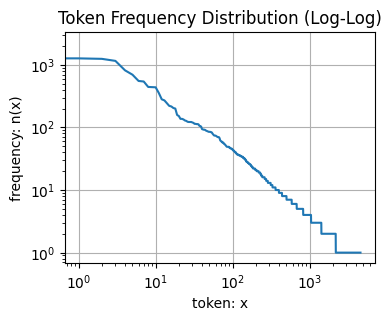

In [38]:
import matplotlib.pyplot as plt

freqs = [freq for token, freq in vocab.token_freqs]

plt.figure(figsize=(4, 3))
plt.plot(freqs)
plt.xlabel('token: x')
plt.ylabel('frequency: n(x)')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.title('Token Frequency Distribution (Log-Log)')
plt.show()

In [39]:
# 因为需要获得的是连续的两个单词，因此他们之间彼此相连，而不是笛卡尔积
bigram_tokens = [pair for pair in zip(corpus[:-1], corpus[1:])]
bigram_vocab = Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]

[(('of', 'the'), 309),
 (('in', 'the'), 169),
 (('i', 'had'), 130),
 (('i', 'was'), 112),
 (('and', 'the'), 109),
 (('the', 'time'), 102),
 (('it', 'was'), 99),
 (('to', 'the'), 85),
 (('as', 'i'), 78),
 (('of', 'a'), 73)]

In [40]:
trigram_tokens = [triple for triple in zip(
    corpus[:-2], corpus[1:-1], corpus[2:])]
trigram_vocab = Vocab(trigram_tokens)
trigram_vocab.token_freqs[:10]

[(('the', 'time', 'traveller'), 59),
 (('the', 'time', 'machine'), 30),
 (('the', 'medical', 'man'), 24),
 (('it', 'seemed', 'to'), 16),
 (('it', 'was', 'a'), 15),
 (('here', 'and', 'there'), 15),
 (('seemed', 'to', 'me'), 14),
 (('i', 'did', 'not'), 14),
 (('i', 'saw', 'the'), 13),
 (('i', 'began', 'to'), 13)]

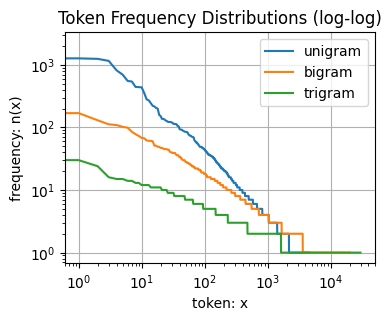

In [41]:
bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]

plt.figure(figsize=(4, 3))
plt.plot(freqs, label='unigram')
plt.plot(bigram_freqs, label='bigram')
plt.plot(trigram_freqs, label='trigram')
plt.xlabel('token: x')
plt.ylabel('frequency: n(x)')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.title("Token Frequency Distributions (log-log)")
plt.show()

In [42]:
# 随机采样：一个batch中，子序列之间是无序的
def seq_data_iter_random(corpus, batch_size, num_steps):  #@save
    """使用随机抽样生成一个小批量子序列"""
    # 从随机偏移量开始对序列进行分区，随机范围包括num_steps-1
    corpus = corpus[random.randint(0, num_steps - 1):]
    # 减去1，是因为我们需要考虑标签，即在最后一个组别的时候，我们也可以通过+1去找到它对应的y
    num_subseqs = (len(corpus) - 1) // num_steps
    # 长度为num_steps的子序列的起始索引
    # 表示从 start 开始，到 stop 之前（不包括stop），每次增加 step 的一个序列。
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    # 在随机抽样的迭代过程中，
    # 来自两个相邻的、随机的、小批量中的子序列不一定在原始序列上相邻
    random.shuffle(initial_indices)

    def data(pos):
        # 返回从pos位置开始的长度为num_steps的序列
        return corpus[pos: pos + num_steps]

    num_batches = num_subseqs // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        # 在这里，initial_indices包含子序列的随机起始索引
        initial_indices_per_batch = initial_indices[i: i + batch_size]
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j + 1) for j in initial_indices_per_batch]
        yield torch.tensor(X), torch.tensor(Y)

In [43]:
my_seq = list(range(35))
for X, Y in seq_data_iter_random(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  tensor([[25, 26, 27, 28, 29],
        [ 0,  1,  2,  3,  4]]) 
Y: tensor([[26, 27, 28, 29, 30],
        [ 1,  2,  3,  4,  5]])
X:  tensor([[20, 21, 22, 23, 24],
        [ 5,  6,  7,  8,  9]]) 
Y: tensor([[21, 22, 23, 24, 25],
        [ 6,  7,  8,  9, 10]])
X:  tensor([[10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19]]) 
Y: tensor([[11, 12, 13, 14, 15],
        [16, 17, 18, 19, 20]])


In [45]:
# 顺序分区：一个batch中，子序列之间也是顺序产生的
def seq_data_iter_sequential(corpus, batch_size, num_steps):  #@save
    """使用顺序分区生成一个小批量子序列"""
    # 从随机偏移量开始划分序列
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = torch.tensor(corpus[offset: offset + num_tokens])
    Ys = torch.tensor(corpus[offset + 1: offset + 1 + num_tokens])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i: i + num_steps]
        Y = Ys[:, i: i + num_steps]
        yield X, Y

In [46]:
for X, Y in seq_data_iter_sequential(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  tensor([[ 4,  5,  6,  7,  8],
        [19, 20, 21, 22, 23]]) 
Y: tensor([[ 5,  6,  7,  8,  9],
        [20, 21, 22, 23, 24]])
X:  tensor([[ 9, 10, 11, 12, 13],
        [24, 25, 26, 27, 28]]) 
Y: tensor([[10, 11, 12, 13, 14],
        [25, 26, 27, 28, 29]])
X:  tensor([[14, 15, 16, 17, 18],
        [29, 30, 31, 32, 33]]) 
Y: tensor([[15, 16, 17, 18, 19],
        [30, 31, 32, 33, 34]])


In [47]:
class SeqDataLoader:  #@save
    """加载序列数据的迭代器"""
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn = seq_data_iter_random
        else:
            self.data_iter_fn = seq_data_iter_sequential
        self.corpus, self.vocab = load_corpus_time_machine(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

In [48]:
def load_data_time_machine(batch_size, num_steps,  #@save
                           use_random_iter=False, max_tokens=10000):
    """返回时光机器数据集的迭代器和词表"""
    data_iter = SeqDataLoader(
        batch_size, num_steps, use_random_iter, max_tokens)
    return data_iter, data_iter.vocab

8.3.5. 小结
语言模型是自然语言处理的关键。

元语法通过截断相关性，为处理长序列提供了一种实用的模型。

长序列存在一个问题：它们很少出现或者从不出现。

齐普夫定律支配着单词的分布，这个分布不仅适用于一元语法，还适用于其他
元语法。

通过拉普拉斯平滑法可以有效地处理结构丰富而频率不足的低频词词组。

读取长序列的主要方式是随机采样和顺序分区。在迭代过程中，后者可以保证来自两个相邻的小批量中的子序列在原始序列上也是相邻的。

英语在NLP中用词根做的比较多，而不是分词或者是char.
